# Overview

* In this experiment, the objective was to develop an object detection model using a dataset provided in COCO JSON format.
* The dataset included eight classes: 'vehicles', 'bicycle', 'bus', 'car', 'motorcycle', 'person', 'taxi', and 'truck'.
* The goal was twofold: to accurately detect objects within images using bounding boxes and to classify these objects into the correct categories.

# Steps and Challenges
**Data Loading and Preprocessing:**

>  I began by loading and preprocessing the data using custom functions [ parse_coco_json and CocoDataGenerator ]. These functions were responsible for parsing the COCO JSON files and extracting the necessary annotations to prepare the data for training.

**Data Augmentation:**
 
> To improve the robustness of the model, I implemented data augmentation techniques, including Rotation, Color Jittering, and Horizontal Flip. These techniques were intended to help the model generalize better to unseen data.

**Model Architecture and Training:**

> * I experimented with several pre-trained models, including ResNet50, CNN, and VGG. Although I initially considered using YOLO for object detection, an unfortunate incident occurred on August 14, 2024, after 6 PM in Syria,where the dataset was suddenly deleted from the site before I could finalize the YOLO model.
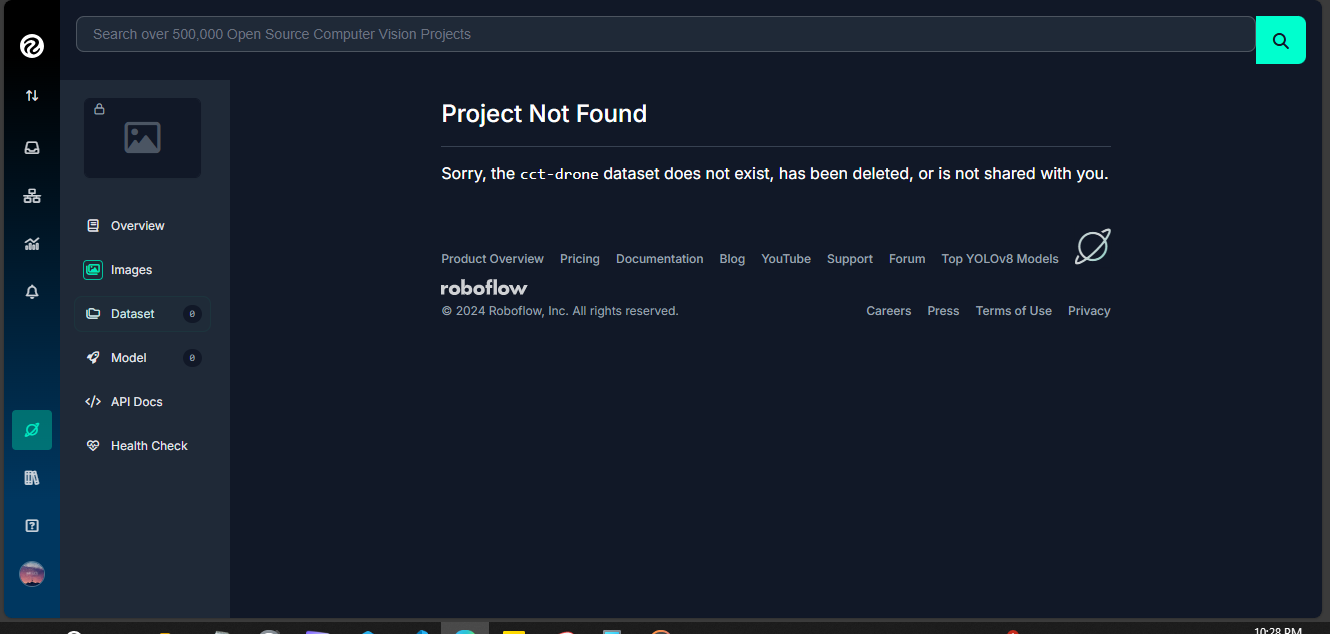

> * During training, I encountered several challenges, particularly with the bounding box predictions. Despite adjusting various hyperparameters and loss functions, the models often produced bounding boxes that did not align correctly with the objects in the images.

**Evaluation:**

>  * The evaluation results indicated that the models were underfitting, as they struggled to learn the necessary patterns from the data. Despite trying different loss functions and metrics, the best model achieved the following results:
>  
> * Precision: 0.4683
> * Recall: 0.2057
> * F1-Score: 0.1652
> * These metrics suggest that the models were not able to effectively detect and classify objects. Upon reflection, I believe the core issue stemmed from the dataset itself, which I discovered too late when trying many training model processes.

# Setup libraries and download data

In [41]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [42]:
!pip install roboflow
!pip install albumentations # this library for augmetation
!pip install pycocotools
!pip install tensorflow opencv-python pycocotools


In [43]:
import os
import json
import tensorflow as tf
import keras 
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from roboflow import Roboflow
import random
from PIL import ImageEnhance, ImageOps
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape,GlobalAveragePooling2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [44]:
rf = Roboflow(api_key="9BndUW4YknDaA9dlfnl4")
project = rf.workspace("carlos-andres-wilches-perez").project("cct-drone")
version = project.version(6)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


# Data Loading and Preprocessing:

**parse_coco_json** is a function that reads a COCO JSON file containing annotations for a dataset of images. It processes and organizes this data into a more accessible format, specifically designed for easy access to image paths, dimensions, and associated annotations

In [45]:
import json
import os

def parse_coco_json(json_file, image_dir):
    with open(json_file, 'r') as f:
        coco_data = json.load(f)

    images_info = coco_data['images']
    annotations_info = coco_data['annotations']
    categories_info = coco_data['categories']

    # Create a mapping from category_id to category_name
    category_map = {category['id']: category['name'] for category in categories_info}

    image_data = {}
    for image in images_info:
        image_id = image['id']
        file_name = image['file_name']
        image_path = os.path.join(image_dir, file_name)
        image_data[image_id] = {
            'image_path': image_path,
            'width': image['width'],
            'height': image['height'],
            'annotations': []
        }

    for annotation in annotations_info:
        image_id = annotation['image_id']
        bbox = annotation['bbox']  # [x_min, y_min, width, height]
        category_id = annotation['category_id']
        category_name = category_map[category_id]

        image_data[image_id]['annotations'].append({
            'bbox': bbox,
            'category_name': category_name
        })

    return image_data


* **CocoDataGenerator** class is used for use in training deep learning models, particularly object detection models, with data organized in the COCO format.
* The generator is designed to provide batches of images and their corresponding annotations (bounding boxes and class labels) to a model during training. 

In [47]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence

class CocoDataGenerator(Sequence):
    def __init__(self, image_data, batch_size, input_size, num_classes, max_boxes=20, augment=False):
        self.image_data = list(image_data.values())
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_classes = num_classes
        self.max_boxes = max_boxes
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_data) / float(self.batch_size)))
    

    def __getitem__(self, idx):
        batch_data = self.image_data[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = np.zeros((len(batch_data), *self.input_size, 3))
        bbox_labels = np.zeros((len(batch_data), self.max_boxes, 4))
        class_labels = np.zeros((len(batch_data), self.max_boxes, self.num_classes))  # Correct shape

        for i, data in enumerate(batch_data):
            image = cv2.imread(data['image_path'])
            image = cv2.resize(image, self.input_size)

            if self.augment:
                image = self.augment_image(image)

            images[i] = image / 255.0  # Normalize

            for j, annotation in enumerate(data['annotations']):
                if j >= self.max_boxes:
                    break
                x_min, y_min, width, height = annotation['bbox']
                x_max = x_min + width
                y_max = y_min + height
                bbox_labels[i, j] = [x_min, y_min, x_max, y_max]

                class_idx = self.class_to_one_hot(annotation['category_name'])
                class_labels[i, j, class_idx] = 1.0

        return images, {'bbox_output': bbox_labels, 'class_output': class_labels}



    def augment_image(self, image):
        # horizontal flip:
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)
        # Color Jittering:
        if np.random.rand() < 0.5:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            image[..., 0] = image[..., 0] + np.random.randint(-10, 10)
            image[..., 1] = image[..., 1] + np.random.randint(-20, 20)
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        # Horizontal flip
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)


        # Rotation
        if np.random.rand() < 0.5:
            angle = np.random.uniform(-15, 15)  # Random rotation angle between -15 and 15 degrees
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
            image = cv2.warpAffine(image, M, (w, h))


        # Adding Gaussian Noise
        if np.random.rand() < 0.5:
            noise = np.random.normal(0, 0.05, image.shape).astype(np.float32)
            image = np.clip(image + noise * 255, 0, 255).astype(np.uint8)
        
        
        return image

    def class_to_one_hot(self, class_name):
        class_mapping = {  # Replace with your actual class mapping
            'vehicles': 0,
            'bicycle': 1,
            'bus': 2,
            'car': 3,
            'motorcycle': 4,
            'person': 5,
            'taxi': 6,
            'truck': 7,
        }
        return class_mapping[class_name]

In [48]:
# reading data path
train_dir = '/kaggle/working/CCT-Drone-6/train'
test_dir ='/kaggle/working/CCT-Drone-6/test'
val_dir ='/kaggle/working/CCT-Drone-6/valid'

train_annotation='/kaggle/working/CCT-Drone-6/train/_annotations.coco.json'
test_annotation='/kaggle/working/CCT-Drone-6/test/_annotations.coco.json'
val_annotation='/kaggle/working/CCT-Drone-6/valid/_annotations.coco.json'

In [49]:
train_data = parse_coco_json(train_annotation, train_dir)
val_data = parse_coco_json(val_annotation, val_dir)
test_data = parse_coco_json(test_annotation, test_dir)


train_generator = CocoDataGenerator(train_data, batch_size=32, input_size=(224, 224), num_classes=8, augment=True)
val_generator = CocoDataGenerator(val_data, batch_size=32, input_size=(224, 224), num_classes=8, augment=False)
test_generator = CocoDataGenerator(test_data, batch_size=32, input_size=(224, 224), num_classes=8, augment=False)

* There are two functions to visualize the distribution of image categories in the training, validation, and test datasets. The **plot_category_counts** function counts the number of images for each category in a given dataset and creates a bar plot to visualize this information. 
* The **display_category_counts_with_plots** function calls plot_category_counts for the training, validation, and test datasets, generating separate plots for each.

In [50]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_category_counts(image_data, dataset_name):
    category_counts = defaultdict(int)

    for data in image_data.values():
        for annotation in data['annotations']:
            category_counts[annotation['category_name']] += 1
            
            
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))  # Use a colormap for different colors

    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.keys(), category_counts.values(), color=colors)
    plt.title(f'{dataset_name} Set Category Counts')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def display_category_counts_with_plots(train_data, val_data, test_data):
    for data, name in zip([train_data, val_data, test_data], ['Training', 'Validation', 'Test']):
        plot_category_counts(data, name)



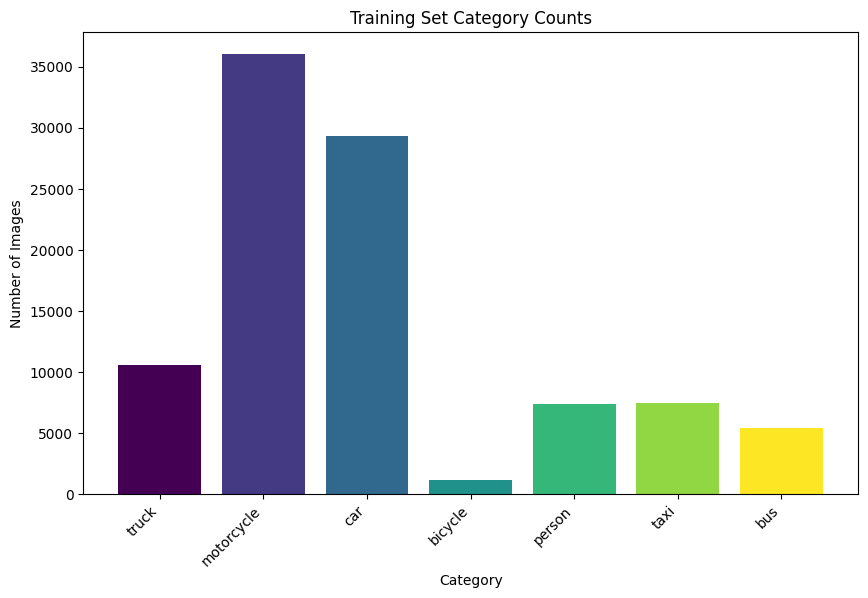

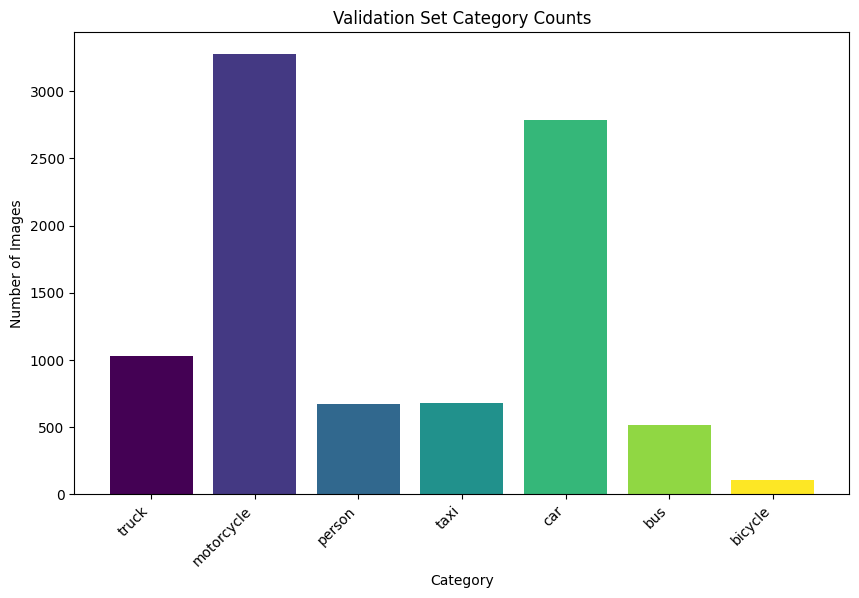

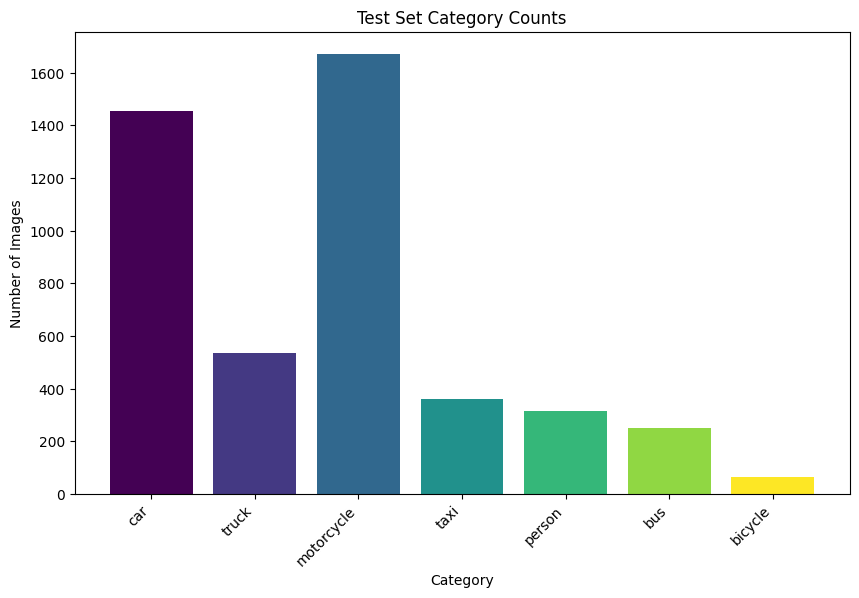

In [51]:
display_category_counts_with_plots(train_data, val_data, test_data)


**We notice that motorcycle and car categories are almost of the data**

**I was trying to balanced the data using the oversamppling , but it gave me the same**

In [52]:
print(train_data[0])

{'image_path': '/kaggle/working/CCT-Drone-6/train/image_00159_png.rf.60ad8d8d18476c56b66f875ed16439a9.jpg', 'width': 640, 'height': 640, 'annotations': [{'bbox': [1, 235, 187, 38], 'category_name': 'truck'}, {'bbox': [175, 212, 19, 9], 'category_name': 'motorcycle'}, {'bbox': [326, 212, 22, 8], 'category_name': 'motorcycle'}, {'bbox': [395, 220, 21, 8], 'category_name': 'motorcycle'}, {'bbox': [476, 207, 20, 10], 'category_name': 'motorcycle'}, {'bbox': [602, 141, 21, 9], 'category_name': 'motorcycle'}, {'bbox': [348, 140, 21, 4], 'category_name': 'motorcycle'}, {'bbox': [304, 148, 20, 10], 'category_name': 'motorcycle'}, {'bbox': [220, 148, 20, 9], 'category_name': 'motorcycle'}, {'bbox': [471, 441, 62, 42], 'category_name': 'truck'}]}


# Building the Models

# ResNet50

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.initializers import HeNormal

def build_model(input_size=(224, 224, 3), num_classes=8, max_boxes=20):
    # Load ResNet50 with pre-trained ImageNet weights, excluding the top layers
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)

    # Unfreeze the last few layers of ResNet for fine-tuning
    for layer in resnet.layers[-30:]:  # Unfreezing the last 30 layers for fine-tuning
        layer.trainable = True

    # Add additional convolutional layers for further feature extraction
    x = resnet.output
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = MaxPooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(512, activation='relu')(x)
    x = Flatten()(x)

    # Bounding Box Regression
    bbox_output = Dense(4 * max_boxes)(x)
    bbox_output = Reshape((max_boxes, 4), name='bbox_output')(bbox_output)

    # Classification
    class_output = Dense(num_classes * max_boxes, activation='softmax')(x)
    class_output = Reshape((max_boxes, num_classes), name='class_output')(class_output)

    # Combine into a Model
    model = Model(inputs=resnet.input, outputs=[bbox_output, class_output])

    return model


In [54]:
input_size=(224, 224, 3)
num_classes=8
max_boxes=20

In [55]:
# i was trying more learning rate : 1e-5,1e-6,1e-7

In [58]:
from tensorflow.keras.losses import Huber,MeanSquaredError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import LogCosh


# Using a lower learning rate and gradient clipping
optimizer = Adam(learning_rate=1e-7, clipnorm=1.0)

# Recompile and re-train
resnet_model = build_model(input_size=input_size, num_classes=num_classes, max_boxes=max_boxes)
resnet_model.compile(optimizer=optimizer, loss={'bbox_output': LogCosh(), 'class_output': 'categorical_crossentropy'},
              metrics={'class_output': 'accuracy'})


In [59]:
# early stop 
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3,
    verbose=1,
    restore_best_weights=True
)



In [61]:
# initializes a learning rate scheduler using TensorFlow's ReduceLROnPlateau callback.
# This callback reduces the learning rate when a monitored metric,
# typically validation loss, stops improving.

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-7,
    verbose=1
)

In [62]:
# fit model
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/20


2024-08-14 06:43:33.025232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1723617822.260426     197 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


317/317 [==============================] - 185s 429ms/step - loss: 144.0007 - bbox_output_loss: 142.7483 - class_output_loss: 1.2523 - class_output_accuracy: 0.1308 - val_loss: 138.2631 - val_bbox_output_loss: 137.3313 - val_class_output_loss: 0.9318 - val_class_output_accuracy: 0.1183 - lr: 1.0000e-07
Epoch 2/20
317/317 [==============================] - 130s 411ms/step - loss: 143.8393 - bbox_output_loss: 142.6592 - class_output_loss: 1.1801 - class_output_accuracy: 0.1307 - val_loss: 138.2706 - val_bbox_output_loss: 137.3174 - val_class_output_loss: 0.9532 - val_class_output_accuracy: 0.1358 - lr: 1.0000e-07
Epoch 3/20
317/317 [==============================] - 130s 410ms/step - loss: 143.7056 - bbox_output_loss: 142.5868 - class_output_loss: 1.1188 - class_output_accuracy: 0.1319 - val_loss: 138.2209 - val_bbox_output_loss: 137.2834 - val_class_output_loss: 0.9375 - val_class_output_accuracy: 0.1533 - lr: 1.0000e-07
Epoch 4/20
317/317 [==============================] - 131s 411ms/s

***we notice that the model is learning but is slow learning. when I made the learning rate big like 1e-4, 1e-5 the loss gave me nan values because can't learn ----> so I put learning rate =1e-7 also I was making many trying to edit hyperparameter about model resNet50, but it gave me the same output also the worse outputs. I tried optimizer parameters like adam optimizer,
 IoU for bbox_output, Huber for loss model.***

# Evaluation

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Function to compute Precision, Recall, and F1-Score
def evaluate_model(model, generator, num_classes):
    y_true = []
    y_pred = []

    for i in range(len(generator)):
        images, labels = generator[i]
        true_class_labels = labels['class_output']

        # Get model predictions
        predictions = model.predict(images, verbose=0)
        predicted_class_labels = predictions[1]  # class_output predictions

        # Flatten the true and predicted labels
        for j in range(len(true_class_labels)):
            y_true.append(np.argmax(true_class_labels[j], axis=-1).flatten())
            y_pred.append(np.argmax(predicted_class_labels[j], axis=-1).flatten())

    # Convert lists to numpy arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")



In [64]:
# Evaluate the model on the test data
evaluate_model(resnet_model, val_generator, num_classes=8)

Precision: 0.5199
Recall: 0.2114
F1-Score: 0.1195


In [65]:
# Evaluate the model on the test data
evaluate_model(resnet_model, test_generator, num_classes=8)


Precision: 0.5545
Recall: 0.2196
F1-Score: 0.1269


In [66]:
# Plot output
import matplotlib.pyplot as plt

def plot_training_history(history, output_dir=None):
    """
    Plot training and validation loss and accuracy from the history object.

    Parameters:
    - history: The history object returned by model.fit().
    - output_dir: If specified, saves the plots to the given directory.
    """
    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('loss', []), label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('class_output_accuracy', []), label='Training Accuracy')
    plt.plot(history.history.get('val_class_output_accuracy', []), label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the plots if output_dir is provided
    if output_dir:
        plt.savefig(f'{output_dir}/training_history.png')
    else:
        plt.show()

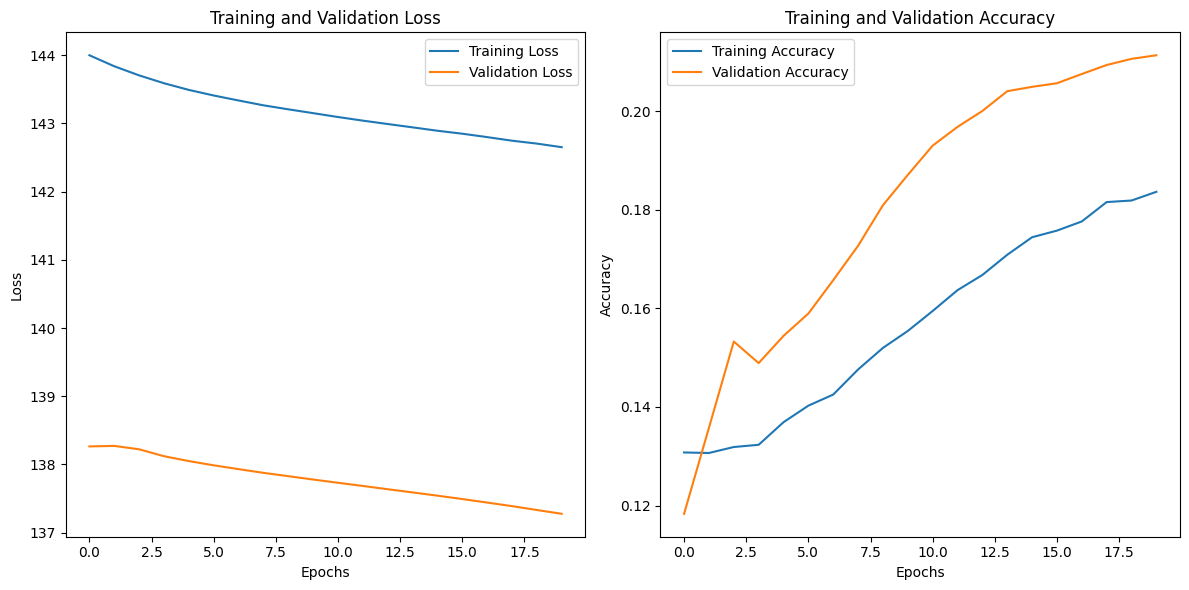

In [67]:
# Plotting
plot_training_history(resnet_history)

In [109]:
# Save the entire model
resnet_model.save('resnet_model.keras')


# CNN model

In [70]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Reshape, BatchNormalization, Dropout, Flatten

def build_cnn_model(input_size=(224, 224, 3), num_classes=8, max_boxes=10):
    # Load ResNet50 with pre-trained ImageNet weights, excluding the top layers
    cnn = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)

    # Additional Convolutional Layers
    x = cnn.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    
    x = Flatten()(x)



    # Bounding Box Regression
    bbox_output = Dense(4 * max_boxes)(x)
    bbox_output = Reshape((max_boxes, 4), name='bbox_output')(bbox_output)
    

    # Classification
    class_output = Dense(num_classes * max_boxes, activation='softmax')(x)
    class_output = Reshape((max_boxes, num_classes), name='class_output')(class_output)
    

    # Combine into a Model
    model = Model(inputs=cnn.input, outputs=[bbox_output, class_output])

    return model


In [72]:
# from tensorflow.keras.optimizers import legacy

optimizer = Adam(learning_rate=1e-7, clipnorm=1.0)

cnn_model = build_cnn_model(input_size=input_size, num_classes=num_classes, max_boxes=max_boxes)


# Compile the model with the legacy optimizer
cnn_model.compile(
    optimizer=optimizer, 
              loss={'bbox_output': MeanSquaredError(), 'class_output': 'categorical_crossentropy'}, 
              loss_weights={'bbox_output': 0.1, 'class_output': 1.0},  # Adjust these weights as needed
              metrics={'class_output': 'accuracy'})
    

In [74]:
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
317/317 [==============================] - 155s 369ms/step - loss: 5617.6758 - bbox_output_loss: 56166.1172 - class_output_loss: 1.0635 - class_output_accuracy: 0.1223 - val_loss: 5365.0103 - val_bbox_output_loss: 53640.0234 - val_class_output_loss: 1.0066 - val_class_output_accuracy: 0.0803 - lr: 1.0000e-07
Epoch 2/20
317/317 [==============================] - 114s 358ms/step - loss: 5616.1616 - bbox_output_loss: 56151.0195 - class_output_loss: 1.0597 - class_output_accuracy: 0.1218 - val_loss: 5365.1787 - val_bbox_output_loss: 53641.4922 - val_class_output_loss: 1.0306 - val_class_output_accuracy: 0.0865 - lr: 1.0000e-07
Epoch 3/20
317/317 [==============================] - 114s 358ms/step - loss: 5614.5942 - bbox_output_loss: 56135.3984 - class_output_loss: 1.0576 - class_output_accuracy: 0.1205 - val_loss: 5361.8770 - val_bbox_output_loss: 53608.9023 - val_class_output_loss: 0.9871 - val_class_output_accuracy: 0.1088 - lr: 1.0000e-07
Epoch 4/20
317/317 [=================

we notice that the loss of model cnn is big than resnet50, and the val accuracy is low also  

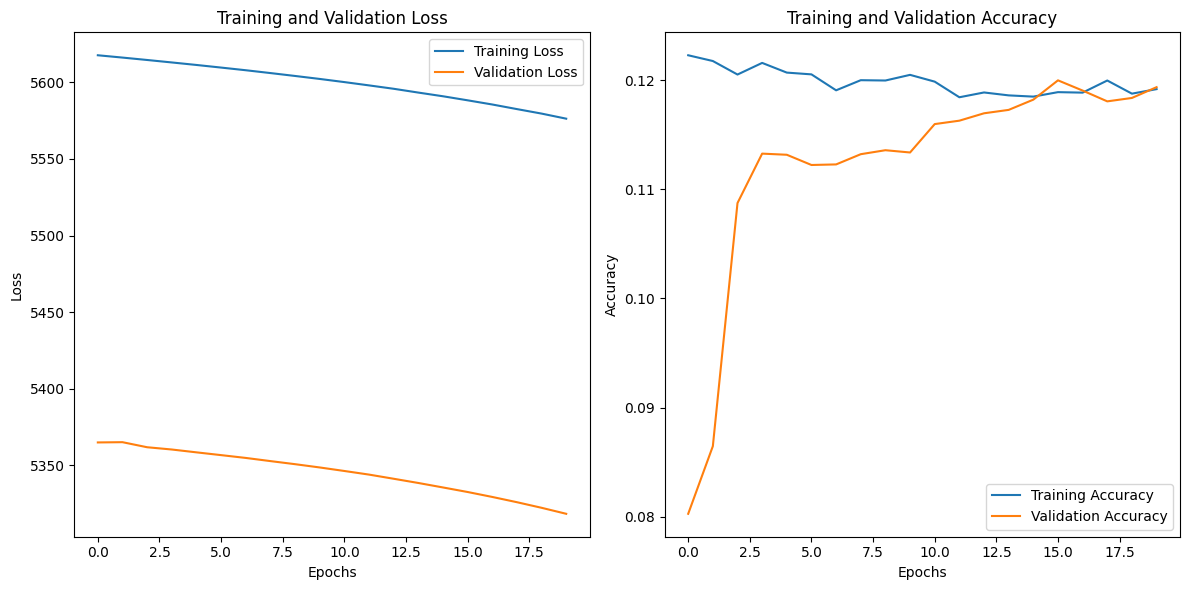

In [75]:
plot_training_history(history_cnn)

**Depend the Resnet model and CNN model, I found the FastRcnn model also had bad val accuracy, I tried to customize the parameters and model layer, but the output was the same.**

In [76]:
# Evaluate the model on the valid data
evaluate_model(cnn_model, val_generator, num_classes=8)

Precision: 0.3431
Recall: 0.1194
F1-Score: 0.1334


In [77]:
# Evaluate the model on the test data
evaluate_model(cnn_model, test_generator, num_classes=8)

Precision: 0.3474
Recall: 0.1278
F1-Score: 0.1419


In [110]:
# Save the entire model
cnn_model.save('cnn_model.keras')


# VGG

**when searching on the internet about relevent bject detection task, it recommended me to use VGG model, but I found also the accuracy was not good, but is better than CNN and ResNet models**

In [101]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

# Freeze the base model (optional: you can also fine-tune some layers later)
base_model.trainable = False

# Create the model
inputs = layers.Input(shape=input_size)

# Use the base model
x = base_model(inputs)

# Add custom layers
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Bounding box output
bbox_output = layers.Dense(max_boxes * 4, activation='sigmoid', name='bbox_output')(x)
bbox_output = layers.Reshape((max_boxes, 4))(bbox_output)

# Class output
class_output = layers.Dense(max_boxes * num_classes, activation='softmax', name='class_output')(x)
class_output = layers.Reshape((max_boxes, num_classes))(class_output)

In [103]:
# Initialize and compile the model
vgg_model = build_vgg16_model(input_size=(224, 224, 3), num_classes=8, max_boxes=20)

# Compile with a higher learning rate
vgg_model.compile(optimizer=Adam(learning_rate=1e-7),
                  loss={'bbox_output': Huber(), 'class_output': 'categorical_crossentropy'},
                  metrics={'class_output': 'accuracy'})


In [104]:
# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
317/317 [==============================] - 84s 255ms/step - loss: 143.6046 - bbox_output_loss: 142.5779 - class_output_loss: 1.0267 - class_output_accuracy: 0.1491 - val_loss: 138.4220 - val_bbox_output_loss: 137.4168 - val_class_output_loss: 1.0052 - val_class_output_accuracy: 0.1606 - lr: 1.0000e-07
Epoch 2/20
317/317 [==============================] - 75s 235ms/step - loss: 143.5640 - bbox_output_loss: 142.5536 - class_output_loss: 1.0104 - class_output_accuracy: 0.1527 - val_loss: 138.3857 - val_bbox_output_loss: 137.3948 - val_class_output_loss: 0.9909 - val_class_output_accuracy: 0.1573 - lr: 1.0000e-07
Epoch 3/20
317/317 [==============================] - 74s 232ms/step - loss: 143.5258 - bbox_output_loss: 142.5307 - class_output_loss: 0.9951 - class_output_accuracy: 0.1606 - val_loss: 138.3482 - val_bbox_output_loss: 137.3724 - val_class_output_loss: 0.9759 - val_class_output_accuracy: 0.1567 - lr: 1.0000e-07
Epoch 4/20
317/317 [==============================] - 74s 

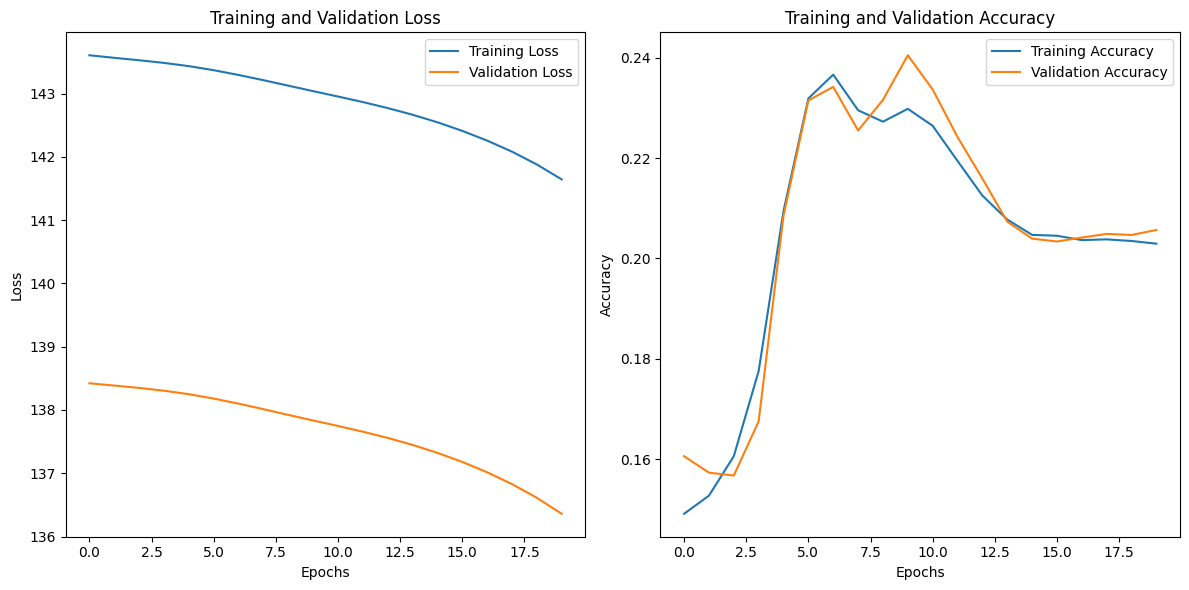

In [105]:
plot_training_history(vgg_history)

In [106]:
#evaluate valid data for VGG  Model
evaluate_model(vgg_model, val_generator, num_classes=8)


Precision: 0.4683
Recall: 0.2057
F1-Score: 0.1652


In [107]:
#evaluate test data for VGG  Model

evaluate_model(vgg_model, test_generator, num_classes=8)


Precision: 0.4792
Recall: 0.2144
F1-Score: 0.1734


In [108]:
# Save the entire model
vgg_model.save('vgg_model.keras')


# YOLO8 model

In [111]:
dataset_yolo = version.download("yolov8")


In [112]:
!pip install ultralytics


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Note: you may need to restart the kernel to use updated packages.


In [122]:
import yaml

# Define the paths to your datasets and class names
data_config = {
    'train': '/kaggle/working/CCT-Drone-6/train',
    'val': '/kaggle/working/CCT-Drone-6/valid',
    'test': '/kaggle/working/CCT-Drone-6/test',
    'names': [
        'vehicles',
        'bicycle',
        'bus',
        'car',
        'motorcycle',
        'person',
        'taxi',
        'truck'
    ]
}

# Specify the output file path
yaml_file_path = '/kaggle/working/CCT-Drone-6/data.yaml'

# Write the data to the YAML file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(data_config, yaml_file, default_flow_style=False)

print(f"data.yaml file created at {yaml_file_path}")

data.yaml file created at /kaggle/working/CCT-Drone-6/data.yaml


In [ ]:
from ultralytics import YOLO

# Initialize the YOLOv8 model
model = YOLO('yolov8n.yaml')  # Choose the appropriate model variant: 'n', 's', 'm', etc.

# Train the model
yolo_model.train(
    data='/kaggle/working/CCT-Drone-6/data.yaml',  # Path to the data.yaml file
    epochs=50,
    imgsz=640,   # Image size
    batch=32,    # Batch size
    name='yolov8n_cct_drone',  # Save the model with a specific name
    # device=0    # Uncomment to use GPU if available
)


**I can't continue building and training  the yolo model because the data was deleted from owner on roboflow site**